# Echo State Network

Time-accurate prediction of the Lorenz system using Echo State Networks.

The netowrks are trained and optimized using Bayesian optimization and the validation strategies described in Racca and Magri (https://doi.org/10.1016/j.neunet.2021.05.004).

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1' # imposes cores
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from scipy.sparse.linalg import eigs as sparse_eigs
import skopt
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
import matplotlib as mpl
from scipy.io import loadmat, savemat
import time
from skopt.plots import plot_convergence

plt.style.use('dark_background')
#Latex
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
# Validation strategies
%run ./Val_Functions.ipynb
# Echo State Network implementation
%run ./Functions.ipynb

### Dataset generation

We start by generating the timeseries of the Lorenz system using forward Euler and splitting the data in washout, training, validation and test.

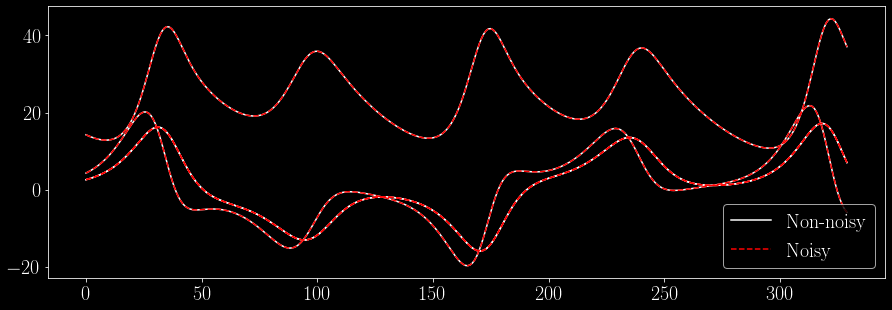

In [2]:
dim = 3

upsample  = 1               # to increase the dt of the ESN wrt the numerical integrator
dt        = 0.01*upsample   # time step
t_lyap    = 0.906**(-1)     # Lyapunov Time (inverse of largest Lyapunov exponent)
N_lyap    = int(t_lyap/dt)  # number of time steps in one Lyapunov time

N_transient = int(200/dt)
u0   = np.random.random((dim))                          #initial random condition
u0   = solve_ode(N_transient, dt/upsample, u0)[-1]      #integrate to reach attractor

# number of time steps for washout, train, validation, test
N_washout = 50
N_train   = 50*N_lyap
N_val     = 3*N_lyap
N_test    = 500*N_lyap
    
# generate data 
U         = solve_ode((N_washout+N_train+N_val+N_test)*upsample, dt/upsample, u0)[::upsample]

# compute normalization factor (range component-wise)
U_data = U[:N_washout+N_train].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m 

# washout
U_washout = U[:N_washout].copy()
# data to be used for training + validation
U_tv  = U[N_washout:N_washout+N_train-1].copy()
Y_tv  = U[N_washout+1:N_washout+N_train].copy()
# plotting part of training data to visualize noise
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 20
plt.plot(U_tv[:N_val,0], c='w', label='Non-noisy')
plt.plot(U_tv[:N_val], c='w')

# adding noise to training set inputs with sigma_n the noise of the data
seed = 0   #to be able to recreate the data
rnd1  = np.random.RandomState(seed)
noisy = True
if noisy:
    data_std = np.std(U,axis=0)
    sigma_n = 0.0001             #change this to increase/decrease noise in training inputs
    for i in range(dim):
        U_tv[:,i] = U_tv[:,i] \
                        + rnd1.normal(0, sigma_n*data_std[i], N_train-1)
    plt.plot(U_tv[:N_val,0], 'r--', label='Noisy')
    plt.plot(U_tv[:N_val], 'r--')

plt.legend()
plt.show()

### ESN Hyperparameters

In [3]:
#network parameters
bias_in   = np.array([1.]) #input bias
bias_out  = np.array([1.]) #output bias 

N_units      = 100 #neurons
connectivity = 3   
sparseness   = 1 - connectivity/(N_units-1) 

tikh = np.array([1e-6,1e-9,1e-12])  # Tikhonov factor (optimize among the values in this list)

###  Grid Search and Bayesian Optimization

Here we set the parameters for Grid Search and Bayesian Optimization.

In [4]:
n_in  = 0           #Number of Initial random points

spec_in     = .1    #range for hyperparameters (spectral radius and input scaling)
spec_end    = 1.   
in_scal_in  = np.log10(0.1)
in_scal_end = np.log10(5.)

# In case we want to start from a grid_search, the first n_grid_x*n_grid_y points are from grid search
n_grid_x = 6  
n_grid_y = 6
n_bo     = 4  #number of points to be acquired through BO after grid search
n_tot    = n_grid_x*n_grid_y + n_bo #Total Number of Function Evaluatuions


# computing the points in the grid
if n_grid_x > 0:
    x1    = [[None] * 2 for i in range(n_grid_x*n_grid_y)]
    k     = 0
    for i in range(n_grid_x):
        for j in range(n_grid_y):
            x1[k] = [spec_in + (spec_end - spec_in)/(n_grid_x-1)*i,
                     in_scal_in + (in_scal_end - in_scal_in)/(n_grid_y-1)*j]
            k   += 1

# range for hyperparameters
search_space = [Real(spec_in, spec_end, name='spectral_radius'),
                Real(in_scal_in, in_scal_end, name='input_scaling')]

# ARD 5/2 Matern Kernel with sigma_f in front for the Gaussian Process
kernell = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-1, 3e0))*\
                  Matern(length_scale=[0.2,0.2], nu=2.5, length_scale_bounds=(5e-2, 1e1)) 


#Hyperparameter Optimization using Grid Search plus Bayesian Optimization
def g(val):
    
    #Gaussian Process reconstruction
    b_e = GPR(kernel = kernell,
            normalize_y = True, #if true mean assumed to be equal to the average of the obj function data, otherwise =0
            n_restarts_optimizer = 3,  #number of random starts to find the gaussian process hyperparameters
            noise = 1e-10, # only for numerical stability
            random_state = 10) # seed
    
    
    #Bayesian Optimization
    res = skopt.gp_minimize(val,                         # the function to minimize
                      search_space,                      # the bounds on each dimension of x
                      base_estimator       = b_e,        # GP kernel
                      acq_func             = "EI",       # the acquisition function
                      n_calls              = n_tot,      # total number of evaluations of f
                      x0                   = x1,         # Initial grid search points to be evaluated at
                      n_random_starts      = n_in,       # the number of additional random initialization points
                      n_restarts_optimizer = 3,          # number of tries for each acquisition
                      random_state         = 10,         # seed
                           )   
    return res

### Validate Echo State
Select validation function to select the hyperparameters for each realization in the ensemble of networks

In [5]:
#Number of Networks in the ensemble
ensemble = 3
# Which validation strategy (implemented in Val_Functions.ipynb)
val      = RVC_Noise
N_fo     = 25                       # number of validation intervals
N_in     = N_washout                # timesteps before the first validation interval (can't be 0 due to implementation)
N_fw     = (N_train-N_val)//(N_fo-1) # how many steps forward the validation interval is shifted (in this way they are evenly spaced)
N_splits = 4                        # reduce memory requirement by increasing N_splits

#Quantities to be saved
par      = np.zeros((ensemble, 4))      # GP parameters
x_iters  = np.zeros((ensemble,n_tot,2)) # coordinates in hp space where f has been evaluated
f_iters  = np.zeros((ensemble,n_tot))   # values of f at those coordinates
minimum  = np.zeros((ensemble, 4))      # minima found per each member of the ensemble

# to store optimal hyperparameters and matrices
tikh_opt = np.zeros(n_tot)
Woutt    = np.zeros(((ensemble, N_units+1,dim)))
Winn     = [] #save as list to keep single elements sparse #np.zeros((ensemble, N_units, dim+1))
Ws       = [] #np.zeros((ensemble,N_units, N_units))

# save the final gp reconstruction for each network
gps      = [None]*ensemble

Realization    : 1
open_loop time: 0.10600852966308594
matrix multiplication time: 0.002864837646484375
linear system time: 0.0003597736358642578
closed-loop time: 0.5380575656890869
Total time per network: 25.54688334465027
Best Results: x 0.45999999999999996 0.47817624989501845 1e-12 f 4.191465808538596


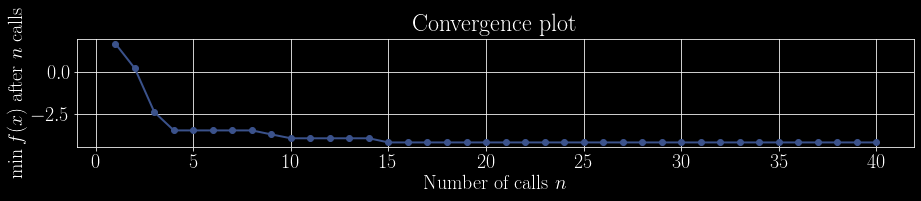

Realization    : 2
open_loop time: 0.1004037857055664
matrix multiplication time: 0.0035181045532226562
linear system time: 0.00034117698669433594
closed-loop time: 0.4983212947845459
Total time per network: 24.968916416168213
Best Results: x 0.7159852121274926 0.3527103975717035 1e-12 f 4.10659196040099


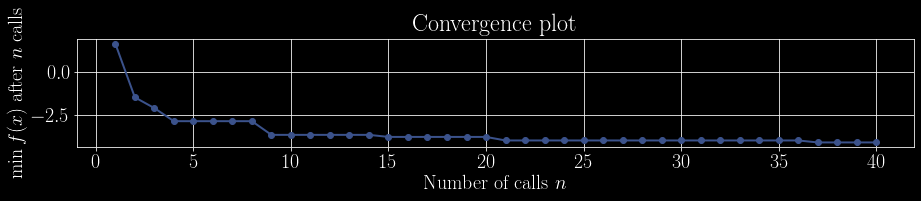

Realization    : 3
open_loop time: 0.15833663940429688
matrix multiplication time: 0.0029058456420898438
linear system time: 0.00031256675720214844
closed-loop time: 0.5020596981048584
Total time per network: 25.43288254737854
Best Results: x 0.5519804046555336 0.494784356168154 1e-12 f 4.313760331103444


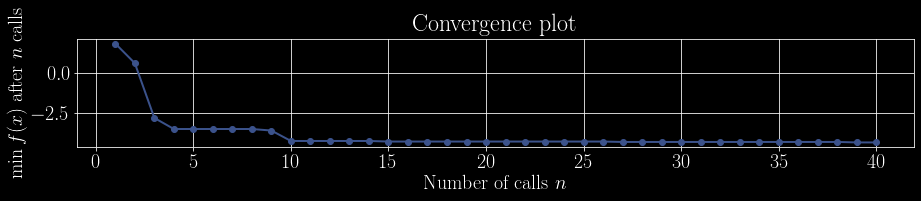

CPU times: user 1min 16s, sys: 103 ms, total: 1min 16s
Wall time: 1min 16s


In [6]:
%%time

# optimize ensemble networks (to account for the random initialization of the input and state matrices)
for i in range(ensemble):
    
    print('Realization    :',i+1)
    
    k   = 0
    
    # Win and W generation
    seed= i+1
    rnd = np.random.RandomState(seed)
    
    #sparse syntax for the input and state matrices
    Win  = lil_matrix((N_units,dim+1)) 
    for j in range(N_units):
        Win[j,rnd.randint(0, dim+1)] = rnd.uniform(-1, 1)
    Win = Win.tocsr()

    W = csr_matrix(
        rnd.uniform(-1, 1, (N_units, N_units)) * (rnd.rand(N_units, N_units) < (1-sparseness)))
    
    spectral_radius = np.abs(sparse_eigs(W, k=1, which='LM', return_eigenvectors=False))[0]
    W = (1/spectral_radius)*W #scaled to have unitary spec radius  
    
    # Bayesian Optimization
    tt       = time.time()
    res      = g(val)
    print('Total time per network:', time.time() - tt)
    
    
    #Saving Quantities for post_processing
    gps[i]     = res.models[-1]    
    gp         = gps[i]
    x_iters[i] = np.array(res.x_iters)
    f_iters[i] = np.array(res.func_vals)
    minimum[i] = np.append(res.x,[tikh_opt[np.argmin(f_iters[i])],res.fun])
    params     = gp.kernel_.get_params()
    key        = sorted(params)
    par[i]     = np.array([params[key[2]],params[key[5]][0], params[key[5]][1], gp.noise_])
    
    #saving matrices
    Woutt[i]   = train_save_n(U_washout, U_tv, U[N_washout+1:N_washout+N_train],
                              minimum[i,2],10**minimum[i,1], minimum[i,0], minimum[i,3])
    Winn    += [Win] 
    Ws      += [W]   
    
    
    #Plotting Optimization Convergence for each network
    print('Best Results: x', minimum[i,0], 10**minimum[i,1], minimum[i,2],
          'f', -minimum[i,-1])
    plt.rcParams["figure.figsize"] = (15,2)
    plt.figure()
    plot_convergence(res)
    plt.show()

## Quick test

Running the networks in the test set to check performance.

Realization    : 1
Hyperparameters: 0.45999999999999996 0.47817624989501845
PH quantiles [Lyapunov Times]: 9.077272727272728 7.949999999999999 6.929545454545455

Realization    : 2
Hyperparameters: 0.7159852121274926 0.3527103975717035
PH quantiles [Lyapunov Times]: 8.672727272727272 7.809090909090909 6.859090909090909

Realization    : 3
Hyperparameters: 0.5519804046555336 0.494784356168154
PH quantiles [Lyapunov Times]: 8.98409090909091 8.3 7.3159090909090905



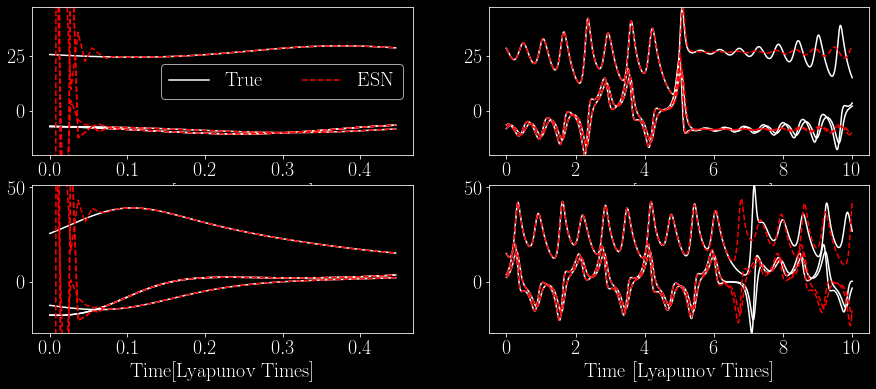

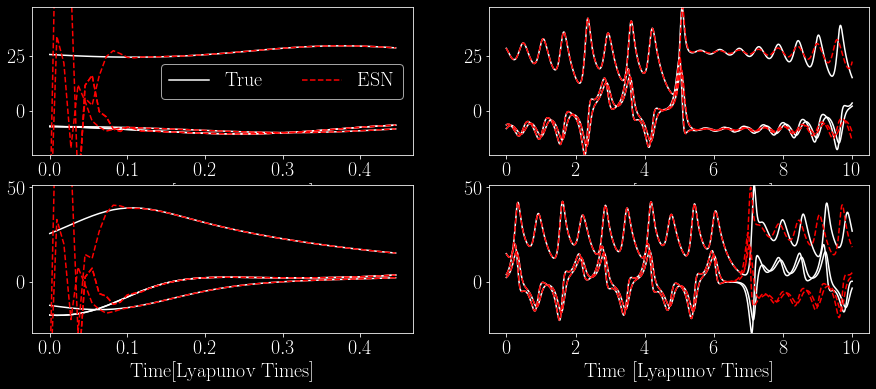

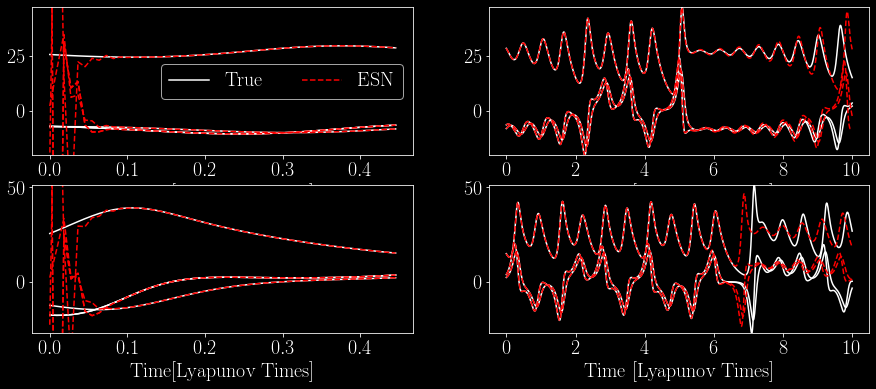

In [10]:
N_test   = 50                       #number of intervals in the test set
N_tstart = N_washout + N_train      #where the first test interval starts
N_intt   = 10*N_lyap                #length of each test set interval

# #prediction horizon normalization factor and threshold
sigma_ph     = np.sqrt(np.mean(np.var(U,axis=1)))
threshold_ph = 0.5

ensemble_test = 3

for j in range(ensemble_test):
    
    print('Realization    :',j+1)
    
    #load matrices and hyperparameters
    Wout     = Woutt[j].copy()
    Win      = Winn[j] #csr_matrix(Winn[j])
    W        = Ws[j]   #csr_matrix(Ws[j])    
    rho      = minimum[j,0].copy()
    sigma_in = 10**minimum[j,1].copy()
    print('Hyperparameters:',rho, sigma_in)
    
    # to store prediction horizon in the test set
    PH       = np.zeros(N_test)
    
    # to plot results
    plot = True
    if plot:
        n_plot = 2
        plt.rcParams["figure.figsize"] = (15,3*n_plot)
        plt.figure()
        plt.tight_layout()
    
    #run different test intervals
    for i in range(N_test):
        
        # data for washout and target in each interval
        U_wash    = U[N_tstart - N_washout +i*N_intt : N_tstart + i*N_intt].copy()
        Y_t       = U[N_tstart + i*N_intt            : N_tstart + i*N_intt + N_intt].copy() 
                
        #washout for each interval
        Xa1     = open_loop(U_wash, np.zeros(N_units), sigma_in, rho)
        Uh_wash = np.dot(Xa1, Wout)
                
        # Prediction Horizon
        Yh_t        = closed_loop(N_intt-1, Xa1[-1], Wout, sigma_in, rho)[0]
        Y_err       = np.sqrt(np.mean((Y_t-Yh_t)**2,axis=1))/sigma_ph
        PH[i]       = np.argmax(Y_err>threshold_ph)/N_lyap
        if PH[i] == 0 and Y_err[0]<threshold_ph: PH[i] = N_intt/N_lyap #(in case PH is larger than interval)

        if plot:
            #left column has the washout (open-loop) and right column the prediction (closed-loop)
            # only first n_plot test set intervals are plotted
            if i<n_plot:
                plt.subplot(n_plot,2,1+i*2)
                xx = np.arange(U_wash[:,-2].shape[0])/N_lyap
                plt.plot(xx,U_wash[:,-2], 'w', label='True')
                plt.plot(xx,Uh_wash[:-1,-2], '--r', label='ESN')
                plt.plot(xx, U_wash[:,:], 'w')
                plt.plot(xx, Uh_wash[:-1,:],'--r')
                plt.ylim(Y_t[:,:].min()-.1, Y_t[:,:].max()+.1)
                plt.xlabel('Time[Lyapunov Times]')
                if i==0:
                    plt.legend(ncol=2)
                plt.subplot(n_plot,2,2+i*2)
                xx = np.arange(Y_t[:,-2].shape[0])/N_lyap
                plt.plot(xx,Y_t[:,:], 'w')
                plt.plot(xx,Yh_t[:,:], '--r')
                plt.ylim(Y_t[:,:].min()-.1, Y_t[:,:].max()+.1)
                plt.xlabel('Time [Lyapunov Times]')
    
    # Percentiles of the prediction horizon
    print('PH quantiles [Lyapunov Times]:', 
          np.quantile(PH,.75), np.median(PH), np.quantile(PH,.25))
    print('')


## Visualize hyperparameter search

Plot performance during validation in hyperpatameter space

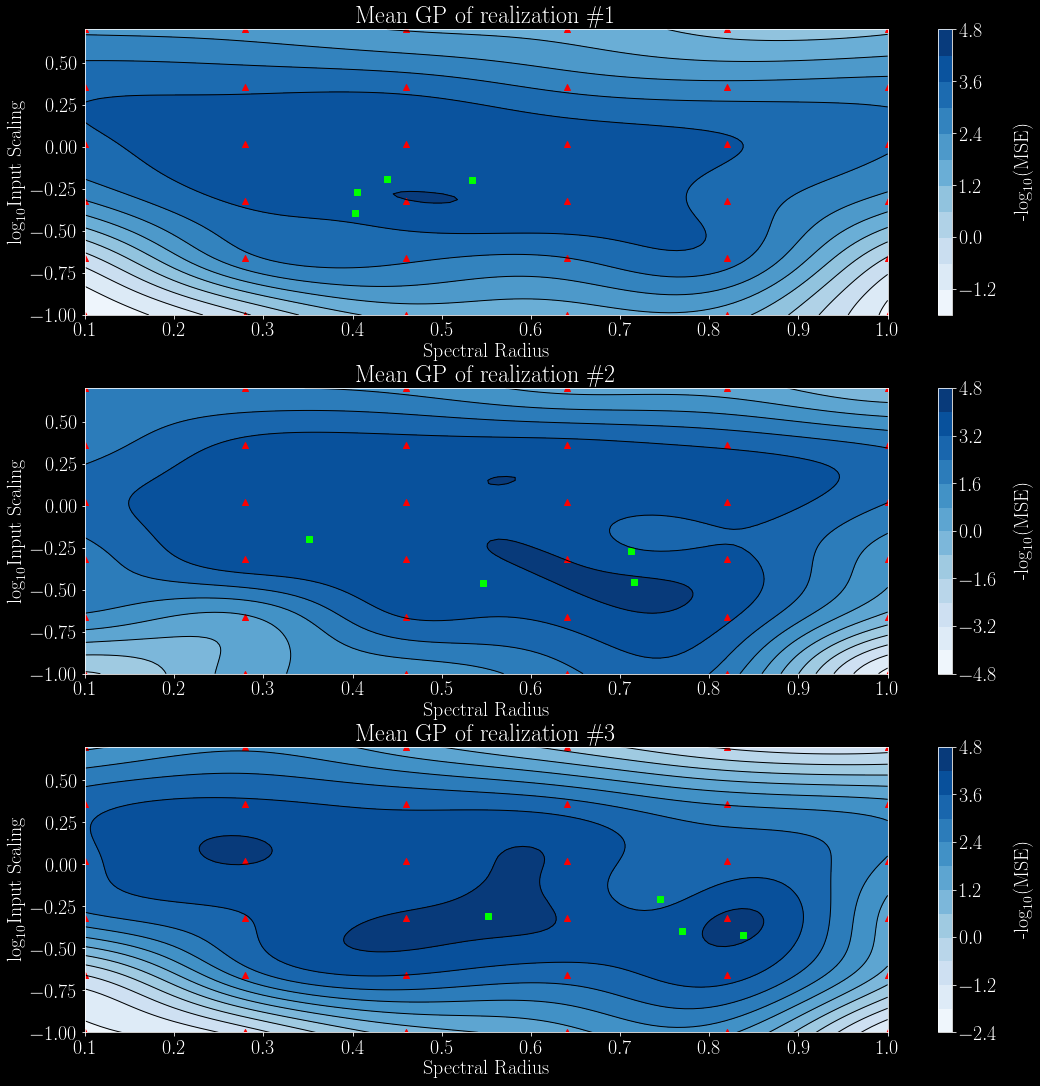

In [8]:
# Plot Gaussian Process reconstruction for each network in the ensemble after n_tot evaluations
# The GP reconstruction is based on the n_tot function evaluations decided in the search

# points to evaluate the GP at
n_length    = 100
xx, yy      = np.meshgrid(np.linspace(spec_in, spec_end,n_length), np.linspace(in_scal_in, in_scal_end,n_length))
x_x         = np.column_stack((xx.flatten(),yy.flatten()))
x_gp        = res.space.transform(x_x.tolist())     ##gp prediction needs this normalized format 
y_pred      = np.zeros((ensemble,n_length,n_length))

plt.rcParams["figure.figsize"] = (15,5*ensemble)
plt.rcParams["font.size"] = 20


fig = plt.figure()

for i in range(ensemble):
    # retrieve the gp reconstruction
    gp         = gps[i]
    
    pred, pred_std = gp.predict(x_gp, return_std=True)
    
    plt.subplot(ensemble, 1, 1+i)
    
    amin = np.amin([10,f_iters.max()])
    
    y_pred[i] = np.clip(-pred, a_min=-amin,
                        a_max=-f_iters.min()).reshape(n_length,n_length) 
                        # Final GP reconstruction for each realization at the evaluation points
        
    plt.title('Mean GP of realization \#'+ str(i+1))
    
    #Plot GP Mean
    plt.xlabel('Spectral Radius')
    plt.ylabel('$\log_{10}$Input Scaling')
    CS      = plt.contourf(xx, yy, y_pred[i],levels=10,cmap='Blues')
    cbar = plt.colorbar()
    cbar.set_label('-$\log_{10}$(MSE)',labelpad=15)
    CSa     = plt.contour(xx, yy, y_pred[i],levels=10,colors='black',
                          linewidths=1, linestyles='solid')    
    
    #   Plot the n_tot search points
    plt.scatter(x_iters[i,:n_grid_x*n_grid_y,0],
                x_iters[i,:n_grid_x*n_grid_y,1], c='r', marker='^') #grid points
    plt.scatter(x_iters[i,n_grid_x*n_grid_y:,0],
                x_iters[i,n_grid_x*n_grid_y:,1], c='lime', marker='s') #bayesian optimization points
    
fig.tight_layout(pad=0.2)
plt.show()

## Save Results

In [9]:
#Save the details and results of the search for post-process
opt_specs = [spec_in,spec_end,in_scal_in,in_scal_end]

fln = './data/ESN_' + val.__name__ + str(N_units) +'.mat'
with open(fln,'wb') as f:  # need 'wb' in Python3
    savemat(f, {"norm": norm})
    savemat(f, {"fix_hyp": np.array([bias_in, N_washout],dtype='float64')})
    savemat(f, {'opt_hyp': np.column_stack((minimum[:,0], 10**minimum[:,1]))})
    savemat(f, {"Win": Winn})
    savemat(f, {'W': Ws})
    savemat(f, {"Wout": Woutt})

# to load in another file
data = loadmat(fln)
Win  = data['Win'][0] #gives Winn